In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Optionally for displaying plots inline
%matplotlib inline


In [2]:
# Load the dataset (replace 'df_arabica_clean.csv' with your file path)
data = pd.read_csv('df_arabica_clean.csv')


In [3]:
# Select numerical columns for clustering
features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Moisture Percentage', 'Balance', 'Overall', 'Total Cup Points (TO BE RECALCULATED)']

# Extract relevant data
X = data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


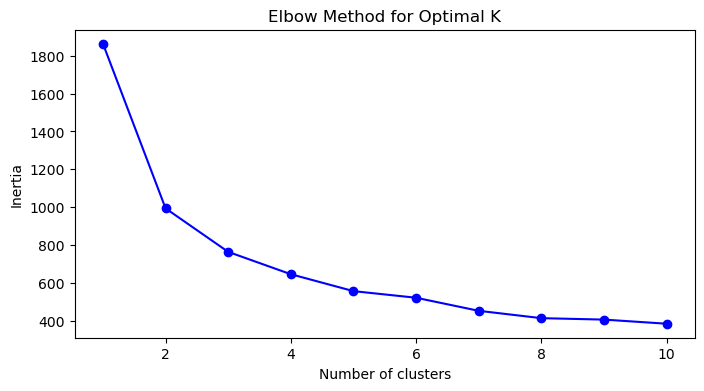

In [7]:
# Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [9]:
# Set the number of clusters based on the elbow method
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

# Get the cluster labels
data['Cluster'] = kmeans.labels_

# Check the first few rows of the dataframe with clusters
data.head()


,ID,Country of Origin,Altitude,Region,Number of Bags,Bag Weight,Harvest Year,Grading Date,Processing Method,Aroma,...,Aftertaste,Acidity,Body,Moisture Percentage,Balance,Overall,Total Cup Points (TO BE RECALCULATED),Category One Defects,Category Two Defects,Cluster
0,0,Colombia,1700-1930,"Piendamo,Cauca",1,35 kg,2021 / 2022,"September 21st, 2022",Double Anaerobic Washed,8.58,...,8.42,8.58,8.25,11.8,8.42,8.58,89.33,0,3,2
1,1,Taiwan,1200,Chiayi,1,80 kg,2021 / 2022,"November 15th, 2022",Washed / Wet,8.50,...,7.92,8.00,7.92,10.5,8.25,8.50,87.58,0,0,2
2,2,Laos,1300,Laos Borofen Plateau,19,25 kg,2021 / 2022,"November 15th, 2022",Semi Washed,8.33,...,8.08,8.17,7.92,10.4,8.17,8.33,87.42,0,2,2
3,3,Costa Rica,1900,"Los Santos,Tarrazu",1,22 kg,2022,"September 21st, 2022",Washed / Wet,8.08,...,8.17,8.25,8.17,11.8,8.08,8.25,87.17,0,0,2
4,4,Colombia,1850-2100,"Popayan,Cauca",2,24 kg,2022,"March 6th, 2023","Honey,Mossto",8.33,...,8.08,8.25,7.92,11.6,7.92,8.25,87.08,0,2,2


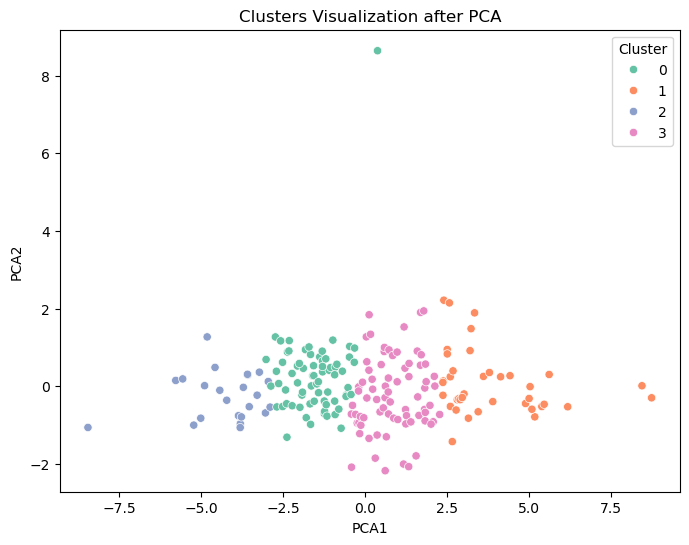

In [11]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a dataframe with PCA components and cluster labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = data['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='Set2')
plt.title('Clusters Visualization after PCA')
plt.show()


In [13]:
# Group by 'Cluster' and calculate the mean for only numeric columns
numeric_columns = data.select_dtypes(include='number').columns  # Select only numeric columns

# Group by 'Cluster' and compute the mean for the numeric columns only
cluster_means = data.groupby('Cluster')[numeric_columns].mean()

# Display the results
cluster_means



,ID,Number of Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Moisture Percentage,Balance,Overall,Total Cup Points (TO BE RECALCULATED),Category One Defects,Category Two Defects,Cluster
Cluster,,,,,,,,,,,,,,
0,58.915493,136.971831,7.855775,7.906197,7.746479,7.832394,7.754648,10.350704,7.781690,7.866197,84.714085,0.084507,1.549296,0.0
1,187.500000,210.789474,7.366579,7.353947,7.246053,7.337895,7.322368,10.763158,7.280789,7.272368,81.177632,0.157895,3.473684,1.0
2,11.043478,31.086957,8.157826,8.163478,8.046957,8.058696,7.960870,10.921739,8.026087,8.133913,86.547391,0.000000,0.826087,2.0
3,130.120000,183.040000,7.639200,7.661467,7.502933,7.621333,7.596533,11.028000,7.580667,7.562267,83.162933,0.213333,2.733333,3.0
